# Exaggeration

In this notebook we want to explore 
- what an embedding without exaggeration looks like throughout the iterations (as well as an overall KLD & KLD change plot)
- effects of different EE stopping iterations on embedding quality (measured by Spearman correlation, 10NN accurcacy and KLD)
- investigate the effects of different EE factors on embedding quality (same as above)
- try all this on 2-3 different datasets

## Preparing the data

### EMNIST dataset (letters)

In [9]:
from emnist import list_datasets
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [13]:
from emnist import extract_training_samples
images, labels = extract_training_samples('letters')
images.shape

(124800, 28, 28)

In [15]:
import pandas as pd
from sklearn.decomposition import PCA
# Flatten MNIST images into 784-dimensional vectors
emnist_data = images.reshape(images.shape[0], -1)  # Shape (60000, 784)
emnist_labels = pd.DataFrame(labels)

# Apply PCA to reduce dimensionality to 50
pca = PCA(n_components=50)
emnist_data_pca = pca.fit_transform(emnist_data)  # Shape (60000, 50)
emnist_data_pca = pd.DataFrame(emnist_data_pca)

In [17]:
emnist_labels.head()

,0
0,23
1,7
2,16
3,15
4,23


In [19]:
def sample_emnist_data(percentage, random_state=12): 
    X_sample = emnist_data_pca.sample(frac=percentage, random_state=random_state).reset_index(drop=True)
    Y_sample = emnist_labels.sample(frac=percentage, random_state=random_state).reset_index(drop=True)
    return X_sample.to_numpy(), Y_sample.to_numpy() 

### small experiments

In [33]:
from openTSNE import TSNE
def run_standard_tsne(data):
    """
    Run standard t-SNE with fixed perplexity and exaggeration.
    """
    tsne = TSNE(perplexity=50, early_exaggeration=12, n_iter=1000, exaggeration=4, n_jobs=-1, random_state=42, verbose=True)
    return tsne.fit(data)

In [34]:
import matplotlib.pyplot as plt 
def plot_tsne_on_emnist(): 
    # run tsne 
    X, labels = sample_emnist_data(0.1)
    embedding = run_standard_tsne(X)
    # Create matplotlib visualisation 
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1, title='standard open t-SNE on EMNIST letters')
    # Create the scatter
    ax.scatter(
        x=embedding[:,0], 
        y=embedding[:,1], 
        c=labels, 
        cmap=plt.colormaps.get_cmap('Paired'), 
        alpha=0.4)
    plt.show()

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, exaggeration=4, n_iter=1000, n_jobs=-1,
     perplexity=50, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 150 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 8.18 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.04 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=1040.00 for 250 iterations...
Iteration   50, KL divergence 5.0960, 50 iterations in 2.3718 sec
Iteration  100, KL divergence 5.1356, 50 iterations in 2.0692 sec
Iteration  150, KL divergence 5.1338, 50 iterations in 2.1244 sec
Iteration  200, KL divergence 5.1338, 50 iterations in 2.1225 sec
Iteration  250, KL divergence 5.1338, 50 iterations in 2.1672 sec
   --> Time elapsed: 10.86 s

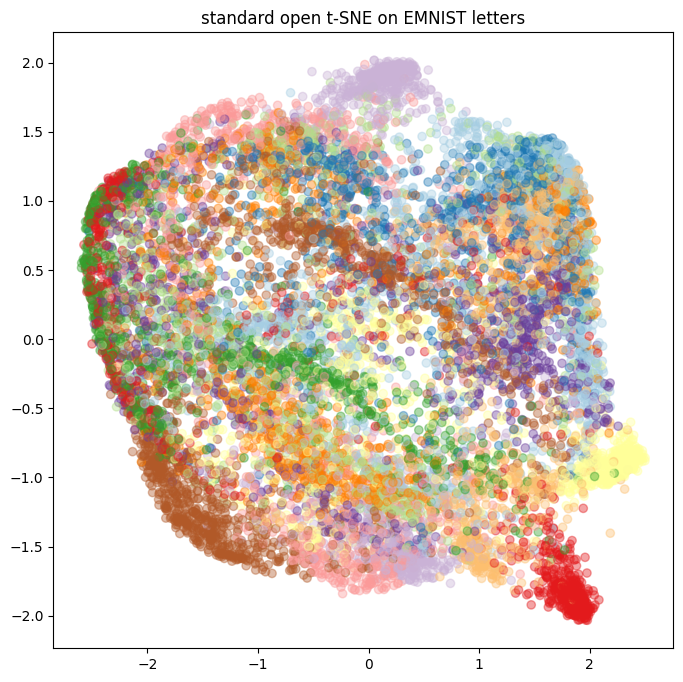

In [35]:
plot_tsne_on_emnist()

## t-SNE with different exaggerations and iterations (no EE stop)

In [37]:
all_emnist_data, all_emnist_labels = sample_emnist_data(1.0)

In [55]:
import openTSNE

In [56]:
def run_multiple_tsne(data, labels, iterations, exaggerations):
    """
    Runs t-SNE for different iterations and exaggerations, returning embeddings in a structured dictionary.

    Parameters:
    - data (ndarray): The input high-dimensional data.
    - labels (ndarray): Labels for coloring the embeddings.
    - iterations (list of int): List of iteration values.
    - exaggerations (list of int): List of exaggeration values.

    Returns:
    - dict: {(iteration, exaggeration): (embedding, labels)}
    """
    # computing affinities and initialization only once  
    affinities = openTSNE.affinity.PerplexityBasedNN(
        data,
        perplexity=30,
        metric="euclidean",
        n_jobs=-1,
        random_state=42,
        verbose=True,
    )

    init = openTSNE.initialization.pca(data, random_state=42)

    embedding_dict = {}

    for iteration in iterations:
        for exaggeration in exaggerations:
            print(f"Running t-SNE: Iter={iteration}, Exag={exaggeration}, no EE stop")
            tsne = openTSNE.TSNEEmbedding(
                init,
                affinities,
                negative_gradient_method="fft",
                n_jobs=-1,
                verbose=True,
            )           
            embedding = tsne.optimize(n_iter=iteration, exaggeration=exaggeration)
            embedding_dict[(iteration, exaggeration)] = (embedding, labels)  # Store result

    return embedding_dict


In [57]:
def plot_throughout_iter(iterations, exaggerations, embeddings):
    """
    Plots a grid of t-SNE embeddings for different iterations and exaggerations.

    Parameters:
    - iterations (list of int): List of iteration values used.
    - exaggerations (list of int): List of exaggeration values used.
    - embeddings (dict): A dictionary where keys are (iteration, exaggeration) tuples, 
                         and values are (embedding_array, labels).
    """

    num_rows = len(exaggerations)  # Each row represents one exaggeration
    num_cols = len(iterations)  # Each column represents one iteration

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

    # Ensure axes is always 2D (for single row/column cases)
    if num_rows == 1:
        axes = [axes]  # Convert to list
    if num_cols == 1:
        axes = [[ax] for ax in axes]  # Convert to list of lists

    # Plot embeddings
    for row_idx, exaggeration in enumerate(exaggerations):
        for col_idx, iteration in enumerate(iterations):
            ax = axes[row_idx][col_idx]
            
            embedding, labels = embeddings[(iteration, exaggeration)]
            ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap="Set1", s=5)
            ax.set_xticks([])
            ax.set_yticks([])

            # Add column headers (iterations)
            if row_idx == 0:
                ax.set_title(f"Iterations: {iteration}", fontsize=12, pad=10)

            # Add row labels (exaggerations)
            if col_idx == 0:
                ax.set_ylabel(f"Exaggeration: {exaggeration}", fontsize=12, labelpad=10)

    plt.tight_layout()
    plt.show()


### 

In [61]:
iterations = [1, 10, 100, 500, 750, 1000, 1500]
exaggerations = [1, 2, 4, 12, 20]

In [ ]:
embeddings = run_multiple_tsne(all_emnist_data, all_emnist_labels, iterations, exaggerations)

===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 81.26 seconds
===> Calculating affinity matrix...


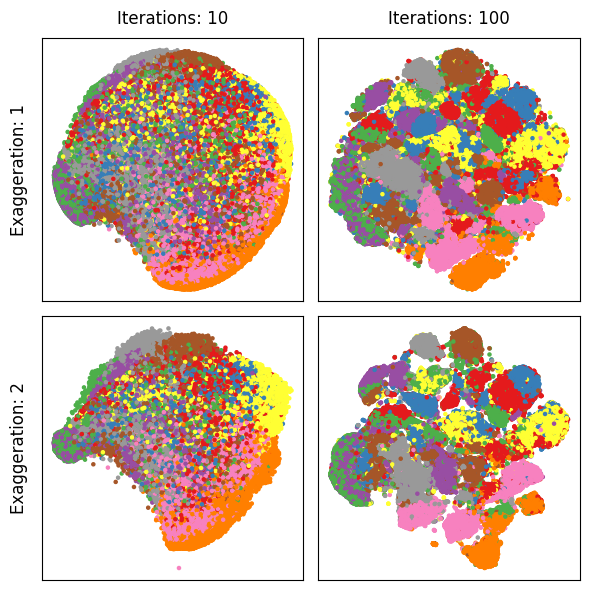

In [60]:
plot_throughout_iter(iterations, exaggerations, embeddings)